# Imbalanced Binary Classification (BER Optimization)

This notebook demonstrates an end-to-end workflow for **imbalanced binary classification**, selecting and tuning models to minimize **Balanced Error Rate (BER)**.

## Highlights
- **Metric-first** evaluation using Balanced Accuracy → **BER = 1 − Balanced Accuracy**
- **Stratified 5-fold cross-validation** for reliable estimates on imbalanced data
- Model comparison (LogReg, Decision Tree, Random Forest, AdaBoost, Bagging)
- Iterative hyperparameter refinement for the selected model


## 1. Setup

Install dependencies (if needed) and import libraries.


In [1]:
# Core
import os
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

# Plotting
import matplotlib.pyplot as plt

RANDOM_STATE = 42


## 2. Data Loading

Update the file paths below to point to your labeled/unlabeled datasets.


In [2]:
# ---- Update these paths as needed ----
LABELED_PATH = "Data/ProjectLABELED2025.xlsx"
UNLABELED_PATH = "Data/ProjectNOTLABELED2025.xlsx"

# Load
if not os.path.exists(LABELED_PATH):
    raise FileNotFoundError(f"Could not find labeled dataset at: {LABELED_PATH}")

df = pd.read_excel(LABELED_PATH)

# Basic cleaning
df = df.dropna()

# Drop index-like column if present
for col in ["Unnamed: 0", "index", "Index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

if "label" not in df.columns:
    raise ValueError("Expected a 'label' column in the labeled dataset.")

X = df.drop(columns=["label"])
y = df["label"]

print("Shape of labeled data:", X.shape)
print("Class distribution:\n", y.value_counts())


Shape of labeled data: (10000, 21)
Class distribution:
 label
0    7503
1    2497
Name: count, dtype: int64


## 3. Quick EDA

A quick look at class imbalance and basic feature types.


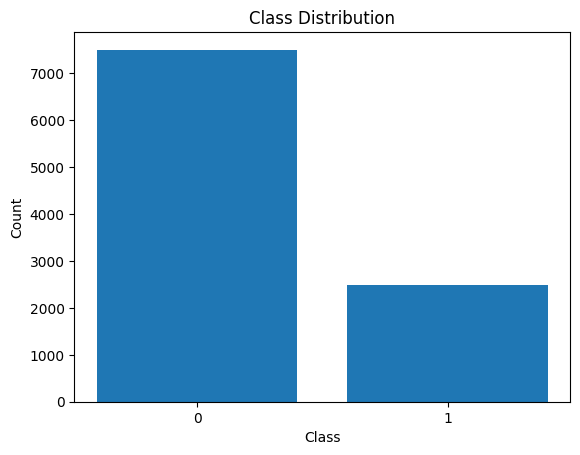

int64      14
float64     7
Name: count, dtype: int64

In [3]:
# Class distribution plot
counts = y.value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Quick dtype summary
X.dtypes.value_counts()


## 4. Metric

We optimize **Balanced Accuracy** during CV and report **BER** as:

\[
\text{BER} = 1 - \text{BalancedAccuracy}
\]


In [4]:
def ber_from_bal_acc(bal_acc: float) -> float:
    return 1.0 - float(bal_acc)

bal_acc_scorer = make_scorer(balanced_accuracy_score)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


## 5. Model Candidates & Hyperparameter Search

We compare several supervised learning models and tune hyperparameters using **GridSearchCV**.


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        random_state=RANDOM_STATE
    ),
    "Bagging": BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
}

param_grids = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10]},
    "Decision Tree": {
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"],
    },
    "Random Forest": {
        "n_estimators": [200, 400, 800],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "class_weight": [None, "balanced"],
    },
    "AdaBoost": {
        "estimator__max_depth": [1, 2],
        "n_estimators": [200, 400, 600],
        "learning_rate": [0.01, 0.03, 0.1],
    },
    "Bagging": {
        "n_estimators": [100, 200, 400],
        "max_samples": [0.5, 0.7, 1.0],
        "max_features": [0.5, 1.0],
        "bootstrap": [True],
        "estimator__max_depth": [None, 5],
    },
}


In [6]:
results = []
best_estimators = {}

for name, model in models.items():
    print(f"\n===== Tuning {name} =====")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=bal_acc_scorer,
        cv=cv,
        n_jobs=-1,
    )
    grid.fit(X, y)

    best_bal_acc = grid.best_score_
    best_ber = ber_from_bal_acc(best_bal_acc)

    print("Best params:", grid.best_params_)
    print(f"Best Balanced Accuracy: {best_bal_acc:.4f}")
    print(f"Best BER: {best_ber:.4f}")

    best_estimators[name] = grid.best_estimator_
    results.append((name, best_bal_acc, best_ber))

# Sort by BER (lower is better)
results_sorted = sorted(results, key=lambda t: t[2])
print("\n===== Model comparison (sorted by BER) =====")
for name, bal_acc, ber in results_sorted:
    print(f"{name:18s} | Balanced Acc = {bal_acc:.4f} | BER = {ber:.4f}")

best_model_name, best_bal_acc, best_ber = results_sorted[0]
best_model = best_estimators[best_model_name]

print(f"\n>>> Best overall model: {best_model_name}")
print(f" Balanced Accuracy = {best_bal_acc:.4f}")
print(f" BER = {best_ber:.4f}")



===== Tuning Logistic Regression =====
Best params: {'C': 1}
Best Balanced Accuracy: 0.5544
Best BER: 0.4456

===== Tuning Decision Tree =====
Best params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Balanced Accuracy: 0.6174
Best BER: 0.3826

===== Tuning Random Forest =====
Best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Balanced Accuracy: 0.6471
Best BER: 0.3529

===== Tuning AdaBoost =====
Best params: {'estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 400}
Best Balanced Accuracy: 0.5948
Best BER: 0.4052

===== Tuning Bagging =====
Best params: {'bootstrap': True, 'estimator__max_depth': 5, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Best Balanced Accuracy: 0.6074
Best BER: 0.3926

===== Model comparison (sorted by BER) =====
Random Forest      | Balanced Acc = 0.6471 | BER = 0.3529
Decision T

## 6. Refining the Selected Model (Random Forest)

If Random Forest is best, we can refine around the best region.


In [7]:
# Run refinement only if Random Forest is the current winner
if best_model_name != "Random Forest":
    print("Random Forest was not the best model in the initial comparison; skipping RF refinement.")
else:
    rf_refined_param_grid = {
        "n_estimators": [200, 400, 600],
        "max_depth": [8, 10, 12, 15],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt"],
        "class_weight": ["balanced"],
    }

    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

    rf_refined_search = GridSearchCV(
        estimator=rf,
        param_grid=rf_refined_param_grid,
        scoring=bal_acc_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    rf_refined_search.fit(X, y)

    rf_best = rf_refined_search.best_estimator_
    rf_best_bal_acc = rf_refined_search.best_score_
    rf_best_ber = ber_from_bal_acc(rf_best_bal_acc)

    print("\n===== Refined Random Forest Results =====")
    print("Best params:", rf_refined_search.best_params_)
    print(f"Best Balanced Accuracy: {rf_best_bal_acc:.4f}")
    print(f"Best BER: {rf_best_ber:.4f}")

    # Micro-refinement
    rf_micro_grid = {
        "n_estimators": [600, 800],
        "max_depth": [7, 8, 9],
        "min_samples_split": [2, 4],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt"],
        "class_weight": ["balanced"],
    }

    rf_micro_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        param_grid=rf_micro_grid,
        scoring=bal_acc_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    rf_micro_search.fit(X, y)

    best_model = rf_micro_search.best_estimator_
    best_model_name = "Random Forest (Refined)"
    best_bal_acc = rf_micro_search.best_score_
    best_ber = ber_from_bal_acc(best_bal_acc)

    print("\n===== Micro-Refined Random Forest Results =====")
    print("Best params:", rf_micro_search.best_params_)
    print(f"Best Balanced Accuracy: {best_bal_acc:.4f}")
    print(f"Best BER: {best_ber:.4f}")



===== Refined Random Forest Results =====
Best params: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best Balanced Accuracy: 0.6551
Best BER: 0.3449

===== Micro-Refined Random Forest Results =====
Best params: {'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 800}
Best Balanced Accuracy: 0.6556
Best BER: 0.3444


## 7. Diagnostics on Cross-Validated Predictions

We generate cross-validated predictions from the selected model to inspect:
- Confusion matrix
- Classification report
- ROC and Precision–Recall curves (when probabilities are available)


              precision    recall  f1-score   support

           0     0.8330    0.7826    0.8070      7503
           1     0.4473    0.5286    0.4846      2497

    accuracy                         0.7192     10000
   macro avg     0.6402    0.6556    0.6458     10000
weighted avg     0.7367    0.7192    0.7265     10000



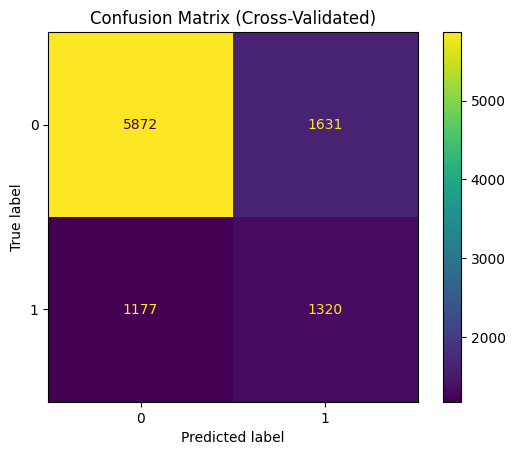

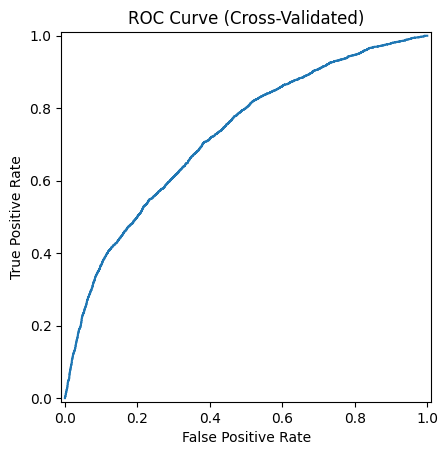

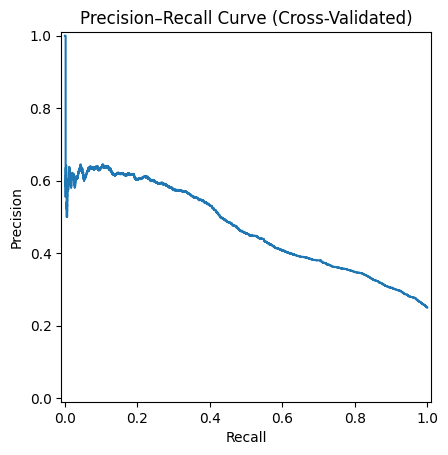

In [8]:
# Cross-validated predictions (labels)
y_pred = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1, method="predict")

print(classification_report(y, y_pred, digits=4))

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Cross-Validated)")
plt.show()

# If model supports predict_proba, show ROC + PR
if hasattr(best_model, "predict_proba"):
    y_proba = cross_val_predict(best_model, X, y, cv=cv, n_jobs=-1, method="predict_proba")[:, 1]

    fpr, tpr, _ = roc_curve(y, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("ROC Curve (Cross-Validated)")
    plt.show()

    prec, rec, _ = precision_recall_curve(y, y_proba)
    PrecisionRecallDisplay(precision=prec, recall=rec).plot()
    plt.title("Precision–Recall Curve (Cross-Validated)")
    plt.show()
else:
    print("Selected model does not support predict_proba; skipping ROC/PR curves.")


## 8. Train Final Model & Predict Unlabeled Data 

This section retrains the selected model on **all labeled data** and writes predictions for the unlabeled dataset.


In [9]:
# Train final model on full labeled dataset
best_model.fit(X, y)

# Predict unlabeled (if provided)
if os.path.exists(UNLABELED_PATH):
    df_u = pd.read_excel(UNLABELED_PATH)

    # Keep an identifier column if present
    id_col = None
    for col in ["Unnamed: 0", "index", "Index"]:
        if col in df_u.columns:
            id_col = col
            break

    ids = df_u[id_col].copy() if id_col else pd.Series(np.arange(len(df_u)), name="id")

    # Drop id-like columns
    if id_col:
        df_u = df_u.drop(columns=[id_col])

    # Ensure same columns/order as training
    missing_cols = [c for c in X.columns if c not in df_u.columns]
    extra_cols = [c for c in df_u.columns if c not in X.columns]
    if missing_cols:
        raise ValueError(f"Unlabeled data is missing columns: {missing_cols}")
    if extra_cols:
        # Drop extras (or handle as needed)
        df_u = df_u.drop(columns=extra_cols)

    df_u = df_u[X.columns]

    preds = best_model.predict(df_u)

    out = pd.DataFrame({
        "index": ids.values,
        "predicted_class": preds
    })

    out_path = "predictions.csv"
    out.to_csv(out_path, index=False)
    print(f"Wrote predictions to: {out_path}")
else:
    print(f"Unlabeled dataset not found at: {UNLABELED_PATH} (skipping).")


Wrote predictions to: predictions.csv


## 9. Conclusions

- Balanced metrics are critical for imbalanced datasets.
- Stratified CV improves stability and fairness of evaluation.
- Ensemble methods (Random Forest) often perform strongly with mixed feature types and limited preprocessing.


In [10]:
#Load Labeled Data
df = pd.read_excel(LABELED_PATH)

df = df.dropna()
df = df.drop(columns=["Unnamed: 0"])

# Split features and label
X = df.drop(columns=["label"])
y = df["label"]

print("Shape of labeled data:", X.shape)
print("Class distribution:\n", y.value_counts())

Shape of labeled data: (10000, 21)
Class distribution:
 label
0    7503
1    2497
Name: count, dtype: int64


In [11]:
param_grids = {

    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
    },

    "Decision Tree": {
        "max_depth": [3, 5, 7, 9],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },

    "Random Forest": {
        "n_estimators": [200, 400, 800],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"],
        "class_weight": [None, "balanced"]
    },

    "AdaBoost": {
        "estimator__max_depth": [1, 2],
        "n_estimators": [200, 400, 600],
        "learning_rate": [0.01, 0.03, 0.1]
    },

    "Bagging": {
        "n_estimators": [100, 200, 400],
        "max_samples": [0.5, 0.7, 1.0],
        "max_features": [0.5, 1.0],
        "bootstrap": [True],
        "estimator__max_depth": [None, 5]
    }
}

In [13]:
#Prediction

# Load unlabeled data
unlabeled = pd.read_excel(UNLABELED_PATH)
unlabeled_index = unlabeled["Unnamed: 0"]
unlabeled_X = unlabeled.drop(columns=["Unnamed: 0"])

# # Predict class labels
unlabeled_preds = best_model.predict(unlabeled_X)

pred_df = pd.DataFrame({
    "index": unlabeled_index,          
    "label": unlabeled_preds           
})

pred_df.to_csv("ProjectPredictions2025_AzrafBakri.csv", index=False)
print("Saved predictions to ProjectPredictions2025_AzrafBakri.csv")


Saved predictions to ProjectPredictions2025_AzrafBakri.csv
